<a href="https://colab.research.google.com/github/ohoudAlmarshdi/Arabic-NLP-classification-/blob/master/Arabic_NLP_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Saudi Novels Classification**
use the content of novels on internet to do a community Analysis for the Saudi writers.

### Problem statement:

classify Saudi novels on internet into its types in literature and use the novels content text feature to predict the category of the Novels using classification. I will describe what makes each class charactitaristically unique, describe what is both certain and uncertain using precision and recall as success metrics.



### Imports

In [1]:


import os
import csv
import glob

import pandas as pd
import numpy as np 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

#modling
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#neural network preprocessing
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import re

#neural network model 
import tensorflow as tf
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras.layers import  Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Import data into Google Colaboratory
The simplest way to share files is to mount your Google Drive.
we will use the drive.mount to connect google drive with colab.

In [2]:
from google.colab import drive
# connect drive with colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


It will ask you to visit a link to ALLOW "Google Files Stream" to access your drive. After that a long alphanumeric auth code will be shown that needs to be entered in your Colab's notebook.

Afterward, your Drive files will be mounted and you can browse them with the file browser in the side panel.

## Data extraction and loading

In [3]:
#extract text from text files then dawnlod it into datafram 
dirpath ='/content/drive/My Drive/TextFiles'
output = 'output_file.csv'
with open(output, 'w') as outfile:
    csvout = csv.writer(outfile)
    csvout.writerow(['FileName', 'Content'])

    files = os.listdir(dirpath)

    for filename in files:
        with open(dirpath + '/' + filename,encoding="utf8",errors='ignore') as afile:
            csvout.writerow([filename,afile.read()])
            afile.close()

    outfile.close()

In [4]:
#dataset reading 
data=pd.read_csv('/content/output_file.csv')

## EDA

In [5]:
#datafrem
data.head()

,FileName,Content
0,بدر سامحني.txt,\nالفصل الاول\n\nانسدحت على السرير ويدها تحت ر...
1,الورطة 2.txt,"\n.................\nنجود تراقب المكان ,, يمكن..."
2,بصدري وجع كنت أحسبه نام يا صدري.txt,\nالرياض ..\nيناظر أبوه وهو يتكلم ..ماتحمل وقا...
3,الواقع المؤلم.txt,ام جوآهر بتعب: جواهر يابنيتي ليه عاد ماتبين تت...
4,بقايا أنثى مجروحة.txt,\n-بالبداية راح أعطيكم نبذة عني أنا مشاعل..عمر...


In [6]:
# the sahpe of the dataset(row,column)
data.shape

(1270, 2)

In [29]:
# content of the first text file
#data['Content'].iloc[0]

In [8]:
# the dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  1270 non-null   object
 1   Content   1268 non-null   object
dtypes: object(2)
memory usage: 20.0+ KB


In [9]:
# function for clean text 
def remove_txt(name):
    name = str(name)
    name = name.replace('.txt', '')
    return name

data['Name'] = data['FileName'].apply(remove_txt)

In [10]:
metadata=pd.read_excel('//content/drive/My Drive/SaudiNovelsMetadata_Ayne_team.xlsx')

In [11]:
metadata.head()

,Name,Author,Year,# of Words,"Parts, if available",content_types,novels_class,country
0,إليك يامن زرعت في قلبي أزهار الربيع,أمك تجيبك وأنا أبتلي,2003.0,20835.0,NaN,دراما - اكشن - جريمة - عسكري,بوليسية,NaN
1,مدرسة المشاغبين السبع !,وردة حمراء,2003.0,178800.0,NaN,رومانسي - مثلية جنسية-مدرسي,اجتماعية,NaN
2,اعترافات رجل يكره يحب يعشق يبغض النساء,سهر الليالي,2004.0,39744.0,NaN,دراما -رومانسية - واقعية,اجتماعية,NaN
3,بقراري ضيعت نفسي و أحبابي,الجوري,2004.0,52384.0,NaN,دراما -رومانسية - واقعية,اجتماعية,NaN
4,ذنبي إني لقيط,الـ ج ـوري,2004.0,32235.0,NaN,دراما- جريمة -واقعية,اجتماعية,NaN


In [12]:

#we need to merge text files with thier content by Name
df = data.merge(metadata, on="Name", how = 'inner')
df.head()

,FileName,Content,Name,Author,Year,# of Words,"Parts, if available",content_types,novels_class,country
0,بدر سامحني.txt,\nالفصل الاول\n\nانسدحت على السرير ويدها تحت ر...,بدر سامحني,بائعة الزهور,NaN,43219.0,NaN,NaN,NaN,NaN
1,الورطة 2.txt,"\n.................\nنجود تراقب المكان ,, يمكن...",الورطة 2,البرق الرومانسي,2011.0,28404.0,NaN,دراما- رومانسية- كوميديا,عاطفية,NaN
2,بضمك ضمة التايه عـن العالم و هو غفيان.txt,كانت جالسه على سريرها وتطالع بجسمها\nودموعها ب...,بضمك ضمة التايه عـن العالم و هو غفيان,NaN,NaN,7127.0,NaN,NaN,NaN,NaN
3,برد وجفا ونسمة هوى 2.txt,الجزء الثاني والثلاثون\nالفصل الأول\nأريد’ أمـ...,برد وجفا ونسمة هوى 2,وصيت قلبي عليك,NaN,77097.0,NaN,NaN,NaN,NaN
4,الموت ولا بعدك يا ولد الناس.txt,\n\nعلى سريرها الكبير .. تتقلب يمين وشمآل .. ض...,الموت ولا بعدك يا ولد الناس,آهآت مبعثرة,2013.0,58021.0,NaN,دراما- رومانسية,عاطفية,NaN


In [13]:
df.shape

(588, 10)

In [14]:
#remove  unnecessary columns
df.drop(['FileName','Parts, if available',"country","Author"],
  axis=1, inplace=True)

In [15]:
#drop null values 
df = df[pd.notnull(df['novels_class'])]

In [16]:
df.shape

(235, 6)

In [17]:
#check classes 
df['novels_class'].value_counts()


عاطفية       106
 عاطفية       53
واقعية        19
اجتماعية      19
 اجتماعية     12
خيالية        11
عاطفية         7
واقعية         5
وجدانية        2
بوليسية        1
Name: novels_class, dtype: int64

we notice that some of the classes duplicate in even it's unique

so maybe it's related to spaces exist in some classes

In [18]:
# function to remove space from our novels_class
def remove_space(word):
    word = str(word)
    word = word.replace(' ','')
    return word

df['novels_class'] = df['novels_class'].apply(remove_space)

In [19]:
df['novels_class'].value_counts()

عاطفية      166
اجتماعية     31
واقعية       24
خيالية       11
وجدانية       2
بوليسية       1
Name: novels_class, dtype: int64

In [20]:
df['Year'].value_counts()

2010.0    65
2011.0    52
2009.0    30
2008.0    27
2012.0    21
2007.0    12
2013.0    11
2006.0     7
2015.0     4
2004.0     2
2003.0     1
2017.0     1
2014.0     1
2005.0     1
Name: Year, dtype: int64

In [21]:
df['Year']=pd.to_datetime(df['Year'], format='%Y')

we have little numbers of values in some classes so we have to remove them.

In [30]:
#remove Number of classes
df = df[df['novels_class'] != "وجدانية"] 
df = df[df['novels_class'] != "بوليسية"] 
df = df[df['novels_class'] != "خيالية"] 


In [31]:
df['novels_class'].value_counts()

عاطفية      166
اجتماعية     31
واقعية       24
Name: novels_class, dtype: int64

Greate!

### Data cleaning :

In [32]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;*%¢π•=]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('arabic'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text= text.replace("\t\t\t", "\t")
    text= text.replace("\r\r\n", "\n")
    text= text.replace("\r\n","\n")
    text= text.replace("\t\n", "\n")
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].str.replace('\d+', '')


### Data preprocessing:

In [33]:
# feature selection  
X=df['Content']

#convert target by using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(df.novels_class)
le.classes_  
y=le.transform(df.novels_class)

print(max(pd.Series(y).value_counts(normalize=True)))

0.751131221719457


In [34]:
# comment tfidf vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', ngram_range=(1, 2), encoding='utf-8')
features = tfidf.fit_transform(X).toarray()
labels = y


In [35]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state = 0)
features.shape


(221, 128240)

In [36]:
print(pd.Series(y).value_counts())


1    166
0     31
2     24
dtype: int64


### Ensemble Modeling

In [37]:

# create list contain of classfication models 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.733202
LogisticRegression        0.751186
MultinomialNB             0.751186
RandomForestClassifier    0.751186
Name: accuracy, dtype: float64

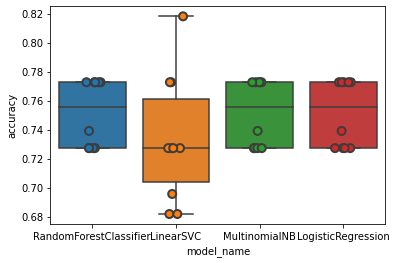

In [38]:

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## LSTM Modeling

- Vectorize consumer complaints text, by turning each text - into either a sequence of integers or into a vector.
- Limit the data set to the top 5,0000 words.
- Set the max number of words in each complaint at 250.

In [39]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 172220 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling.

In [40]:
X = tokenizer.texts_to_sequences(df['Content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (221, 250)


Converting categorical labels to numbers.


In [41]:
Y = pd.get_dummies(df["novels_class"]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (221, 3)


Train test split.


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(198, 250) (198, 3)
(23, 250) (23, 3)


### model building:

In [43]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/100
3/3 [==============================] - 1s 416ms/step - loss: 1.0888 - accuracy: 0.5225 - val_loss: 1.0546 - val_accuracy: 0.7500
Epoch 2/100
3/3 [==============================] - 1s 307ms/step - loss: 1.0376 - accuracy: 0.7416 - val_loss: 1.0009 - val_accuracy: 0.7500
Epoch 3/100
3/3 [==============================] - 1s 295ms/step - loss: 0.9679 - accuracy: 0.7416 - val_loss: 0.9168 - val_accuracy: 0.7500
Epoch 4/100
3/3 [==============================] - 1s 317ms/step - loss: 0.8664 - accuracy: 0.7416 - val_loss: 0.8037 - val_accuracy: 0.7500
Epoch 5/100
3/3 [==============================] - 1s 293ms/step - loss: 0.7670 - accuracy: 0.7416 - val_loss: 0.8786 - val_accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 1s 306ms/step - loss: 0.7636 - accuracy: 0.7416 - val_loss: 0.8315 - val_accuracy: 0.7500
Epoch 7/100
3/3 [==============================] - 1s 293ms/step - loss: 0.7101 - accuracy: 0.7416 - val_loss: 0.7864 - val_accuracy: 0.7500
Epoch 8/100
3

### model evaluation:

In [44]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.8261
Test set
  Loss: 0.655
  Accuracy: 0.826


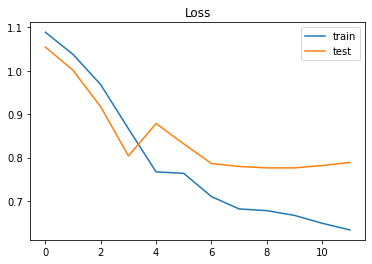

In [45]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

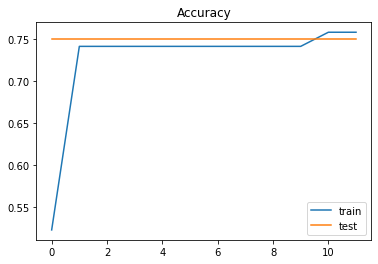

In [46]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

The plots suggest that the model has a little over fitting problem, more data may help, but more epochs will not help using the current data.